# Final Model Iterations

I use my latest cleaned df here without area code. 

I split my data correctly and one hot encode my data correctly before modeling.

In [69]:
# imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# variable for file path from this directory
to_data = '../../../data/'

In [50]:
# import latest 
df = pd.read_csv('drop_areacode_lc', index_col = 0)
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## More Cleaning

### Change `international_plan` and `voice_mail_plan` to 1/0's and change to category type

In [51]:
binary = ['voice_mail_plan', 'international_plan', 'churn']
for col in binary:
    df[col].replace((True, False), (1, 0), inplace = True)
    df[col] = df[col].astype('category')

In [53]:
df.to_csv('binary_cats_lc')

# Prepare for Modelling:

## Create features and target variables:

In [54]:
X = df.drop('churn', axis = 1)
y = df.churn

## Dummy variables:

In [55]:
X = pd.get_dummies(X, drop_first = True)

In [56]:
X

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_1,voice_mail_plan_1
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0,0,0,0,0,0,0,0,0,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0,0,0,0,0,0,0,0,0,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0,0,0,0,0,0,0,0,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0,0,0,0,0,0,0,0,1,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,...,0,0,0,0,0,0,0,0,0,1
3329,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,...,0,0,0,0,0,0,1,0,0,0
3330,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,...,0,0,0,0,0,0,0,0,0,0
3331,184,0,213.8,105,36.35,159.6,84,13.57,139.2,137,...,0,0,0,0,0,0,0,0,1,0


In [94]:
X.to_csv('X_dummy_lc')

In [96]:
y.to_csv('y_lc')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Train, test, split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

## One Hot Encode

In [17]:
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

In [18]:
# Fit ohe on training data:
to_ohe = ['state', 'international_plan', 'voice_mail_plan']

In [35]:
ohe.fit(X_train[to_ohe])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=False)

In [36]:
#view categories
print(ohe.categories_)

[array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object), array([False,  True]), array([False,  True])]


In [30]:
# make df with encoded columns:
train_encoded = pd.DataFrame(ohe.transform(X_train[['state']]),
                                  index = X_train.index,
                                  columns = ohe.categories_[0])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7497 but corresponding boolean dimension is 2499

In [32]:
    
train_encoded = pd.DataFrame(ohe.transform(X_train[to_ohe]),
                              index = X_train.index,
                              columns = ohe.categories_)

ValueError: all arrays must be same length

In [10]:
X_train_encoded

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
2519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


I'm not going to worry about OHE right now because I can't figure this out with the column names.

# Modelling

Create function for modeling with training and validation data that scales and balances using SMOTE.

In [61]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), X_train.columns.values, fontsize = 12) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importance', fontsize = 20)

In [110]:
def scale_balance_model(X_train, y_train, model, scaler = StandardScaler()):
    # create kfolds object
    kf = KFold(n_splits = 5, random_state = 15)
    
    # create list to add recall scores
    validation_recall = []
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
        
        # instantiate and fit/transform scaler
        scaler = scaler
        X_t_sc = scaler.fit_transform(X_t)
        X_val_sc = scaler.transform(X_val)
        
        # instantiate and fit SMOTE:
        smote = SMOTE(random_state = 15)
        X_t_resampled, y_t_resampled = smote.fit_resample(X_t_sc, y_t)
        
        # fit model to X_t_resampled:
        model.fit(X_t_resampled, y_t_resampled)
        
        # append recall score to validation recall list:
        validation_recall.append(recall_score(y_val, model.predict(X_val_sc)))
        
    print(f"Validation recall scores: {validation_recall}")
    print(f"Mean recall score:  {np.mean(validation_recall)}")
    print(f"Confusion Matrix: \n {confusion_matrix(y_val, model.predict(X_val_sc))}")
    
    plot_feature_importances(model)

## FSM:  Decision Tree

Validation recall scores: [0.7, 0.8024691358024691, 0.7638888888888888, 0.7692307692307693, 0.7083333333333334]
Mean recall score:  0.748784425451092
Confusion Matrix: 
 [[409  18]
 [ 21  51]]


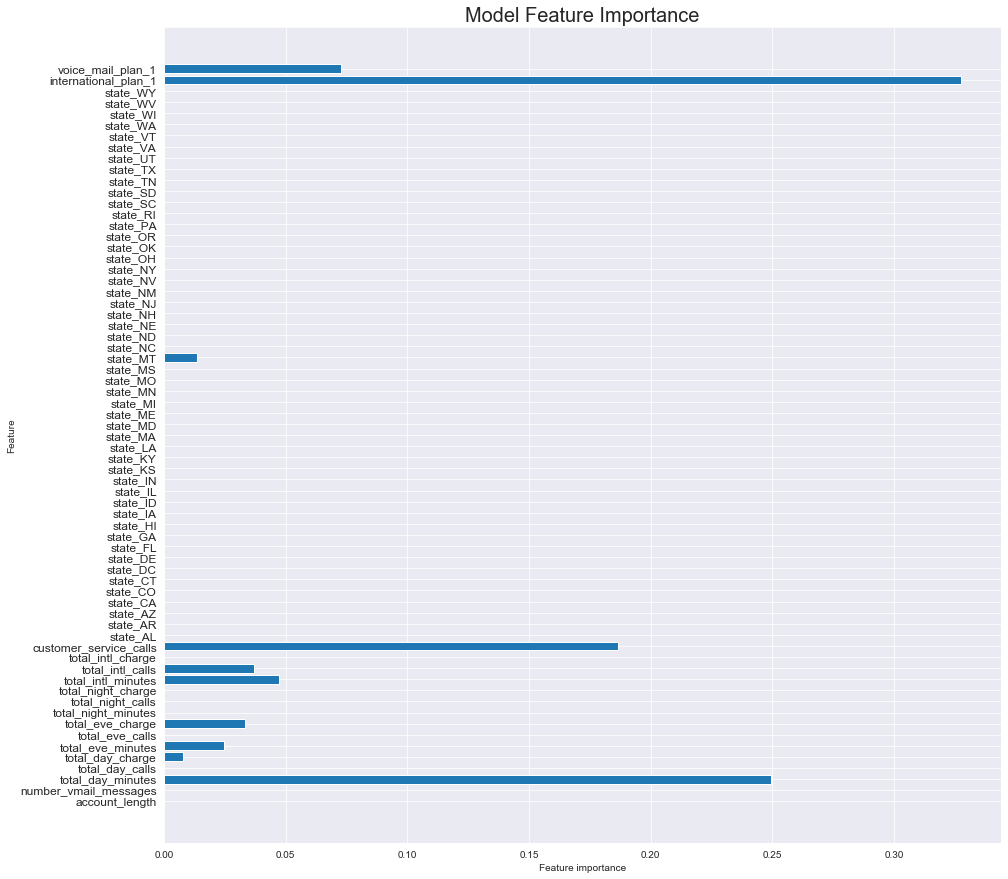

In [111]:
# fsm:  decision tree with max_depth = 5:
scale_balance_model(X_train, y_train, DecisionTreeClassifier(max_depth = 5, random_state = 15))

Not bad for a first model.  Let's try a logistic regression model now:

## Model 2:  Logistic Regression model

In [112]:
scale_balance_model(X_train, y_train, LogisticRegression(solver = 'liblinear', random_state = 15))

Validation recall scores: [0.6857142857142857, 0.6172839506172839, 0.7083333333333334, 0.6923076923076923, 0.6111111111111112]
Mean recall score:  0.6629500746167414
Confusion Matrix: 
 [[358  69]
 [ 28  44]]


AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

<Figure size 1080x1080 with 0 Axes>

We can ignore the last error.  This model wasn't as good as the decision tree so let's now try a random forest model:

## Model 3:  Vanilla Random Forest

Validation recall scores: [0.7571428571428571, 0.7407407407407407, 0.8055555555555556, 0.8, 0.6805555555555556]
Mean recall score:  0.7567989417989418
Confusion Matrix: 
 [[404  23]
 [ 23  49]]


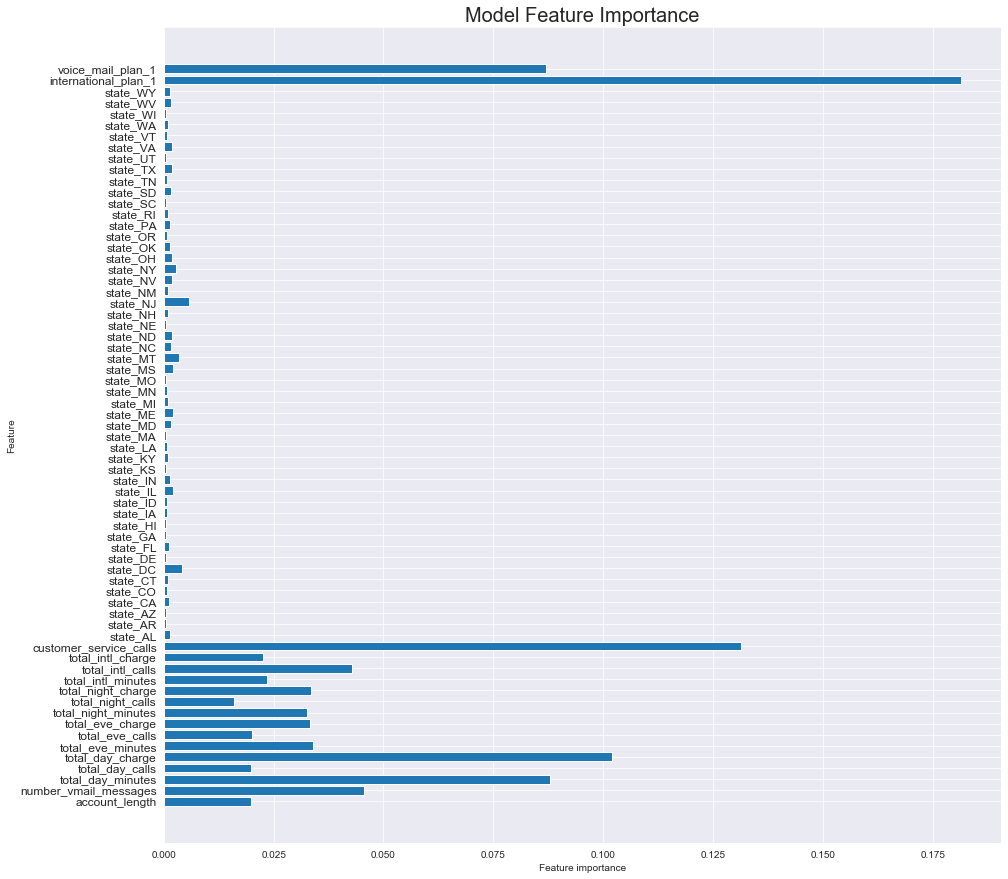

In [113]:
scale_balance_model(X_train, y_train, RandomForestClassifier(n_estimators = 100, max_depth = 10, max_features = 10, random_state = 15))

This appears to do much better.  Let's mess around with some of the hyperparameters for random forest.

## Model 4:  Random Forest - first tuning:

Validation recall scores: [0.7857142857142857, 0.7160493827160493, 0.7916666666666666, 0.8153846153846154, 0.6527777777777778]
Mean recall score:  0.7523185456518788
Confusion Matrix: 
 [[392  35]
 [ 25  47]]


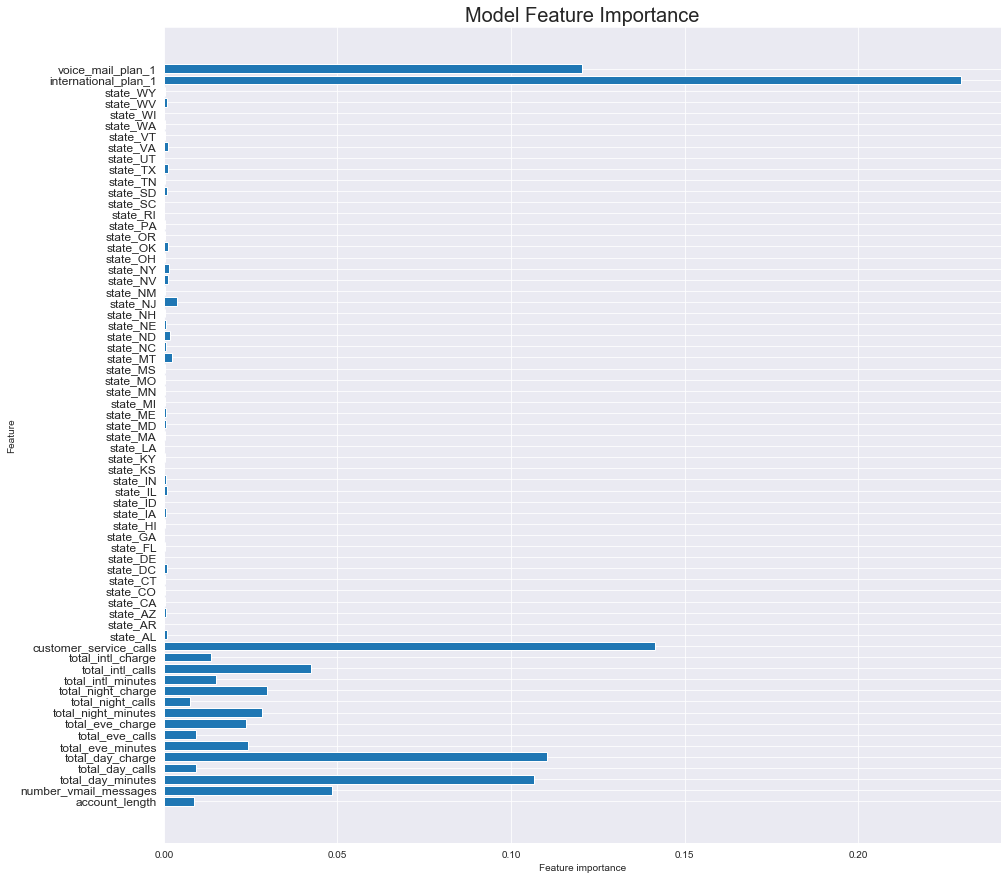

In [114]:
scale_balance_model(X_train, y_train, RandomForestClassifier(n_estimators = 1000, max_depth = 5, max_features = 10, random_state = 15))

Not as good... let's maybe try a different criterion.

## Model 5: Random Forst - second tuning

Validation recall scores: [0.7571428571428571, 0.7530864197530864, 0.8194444444444444, 0.8307692307692308, 0.7083333333333334]
Mean recall score:  0.7737552570885905
Confusion Matrix: 
 [[404  23]
 [ 21  51]]


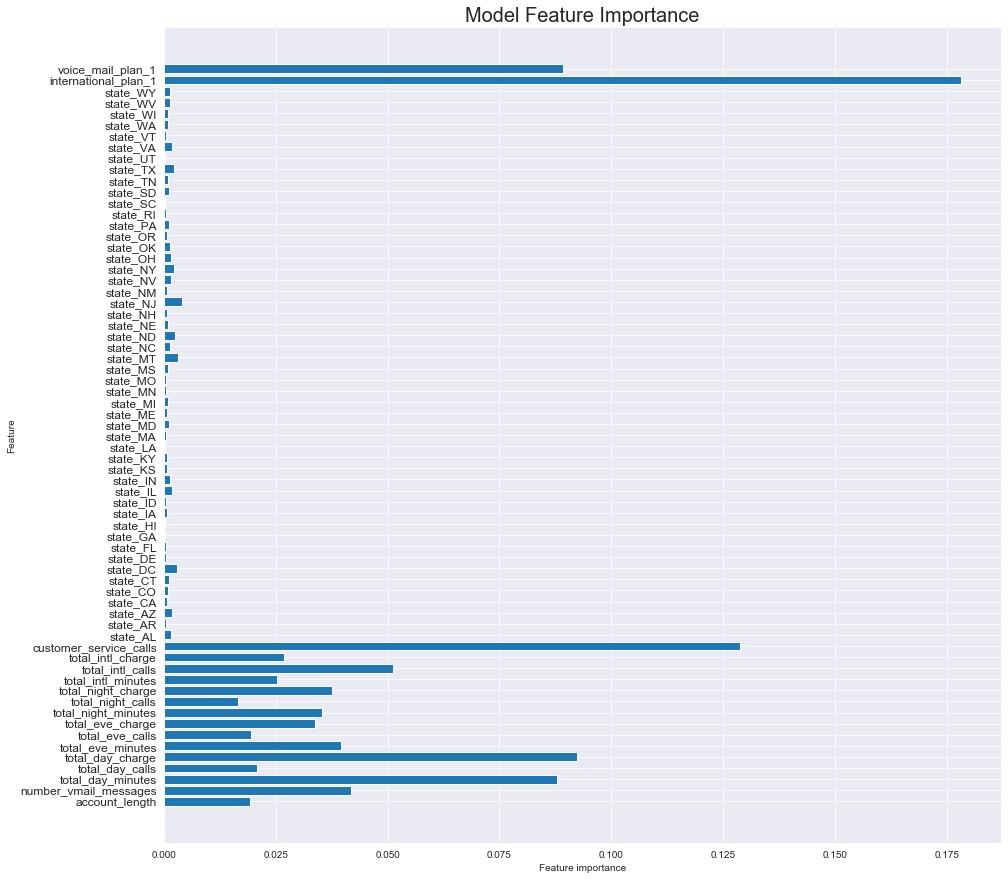

In [115]:
scale_balance_model(X_train, y_train, RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 10, max_features = 10, random_state = 15))

Still not as good as model 3.

Model 3 is our best so far with a validation recall score of 0.773 and is a random forest model.  

Let's try out some gradient boost models.

## Model 6:  Vanilla Gradient Boost Model

Validation recall scores: [0.7857142857142857, 0.8148148148148148, 0.7916666666666666, 0.8, 0.6527777777777778]
Mean recall score:  0.768994708994709
Confusion Matrix: 
 [[413  14]
 [ 25  47]]


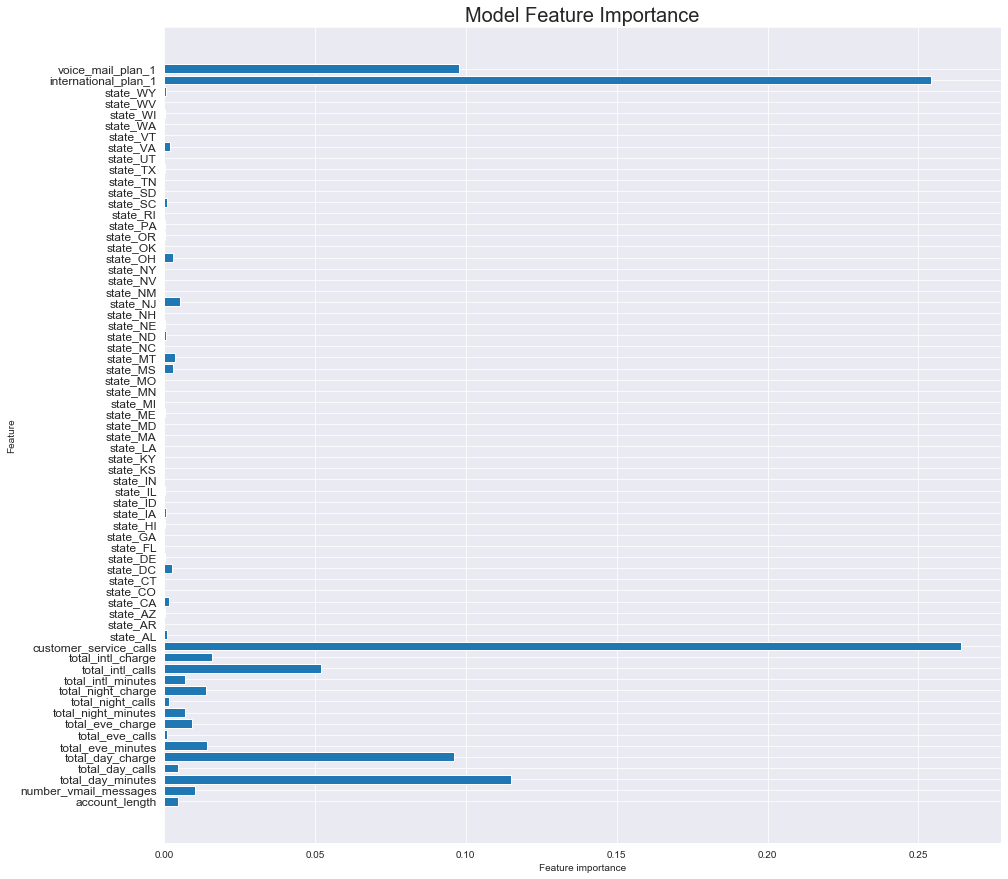

In [116]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(random_state = 15))

Not as good as model 3.

## Model 7:  Gradient boost - first tuning

Try min max scaler

Validation recall scores: [0.7571428571428571, 0.8518518518518519, 0.7916666666666666, 0.7692307692307693, 0.6666666666666666]
Mean recall score:  0.7673117623117622
Confusion Matrix: 
 [[412  15]
 [ 24  48]]


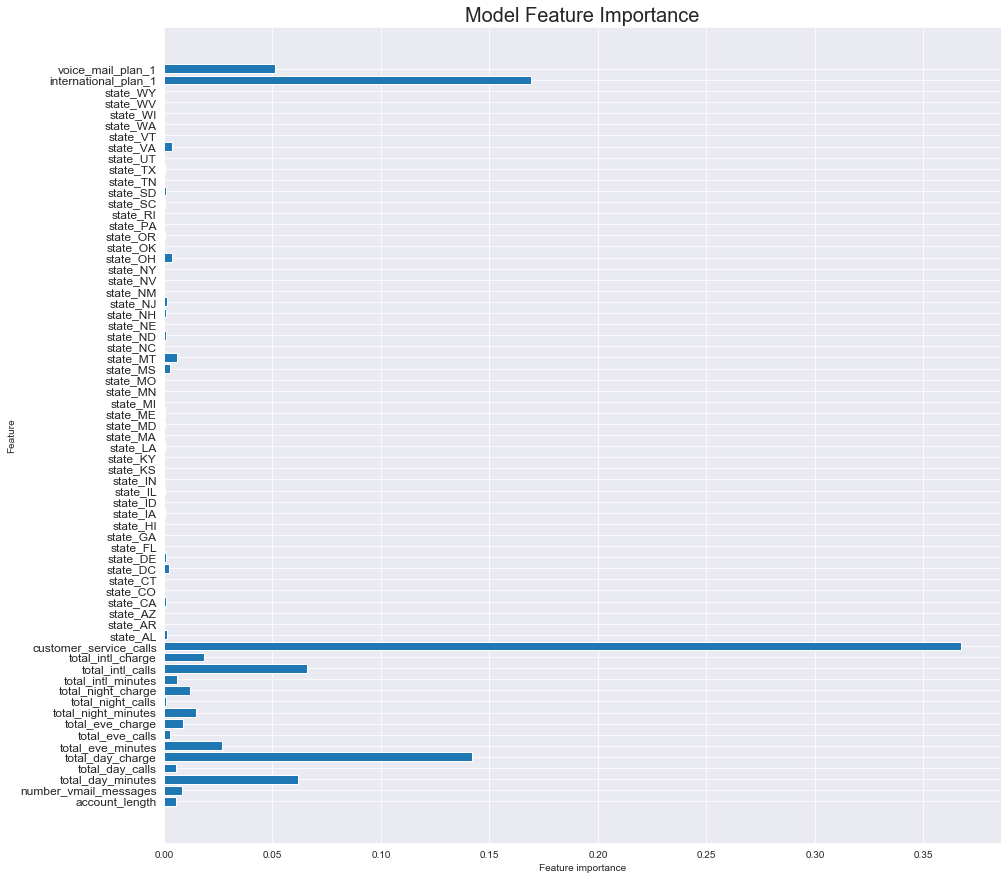

In [117]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(random_state = 15), MinMaxScaler())

Better than model 3 - **new best model**.

So scores were better using a MinMax Scaler.  Let's tune more parameters.

## Model 8:  Gradient Boost - second tuning

Change loss parameter to 'exponential' (this essentially makes it an adaboost model right??)

Validation recall scores: [0.7571428571428571, 0.8148148148148148, 0.8055555555555556, 0.7692307692307693, 0.6944444444444444]
Mean recall score:  0.7682376882376882
Confusion Matrix: 
 [[409  18]
 [ 22  50]]


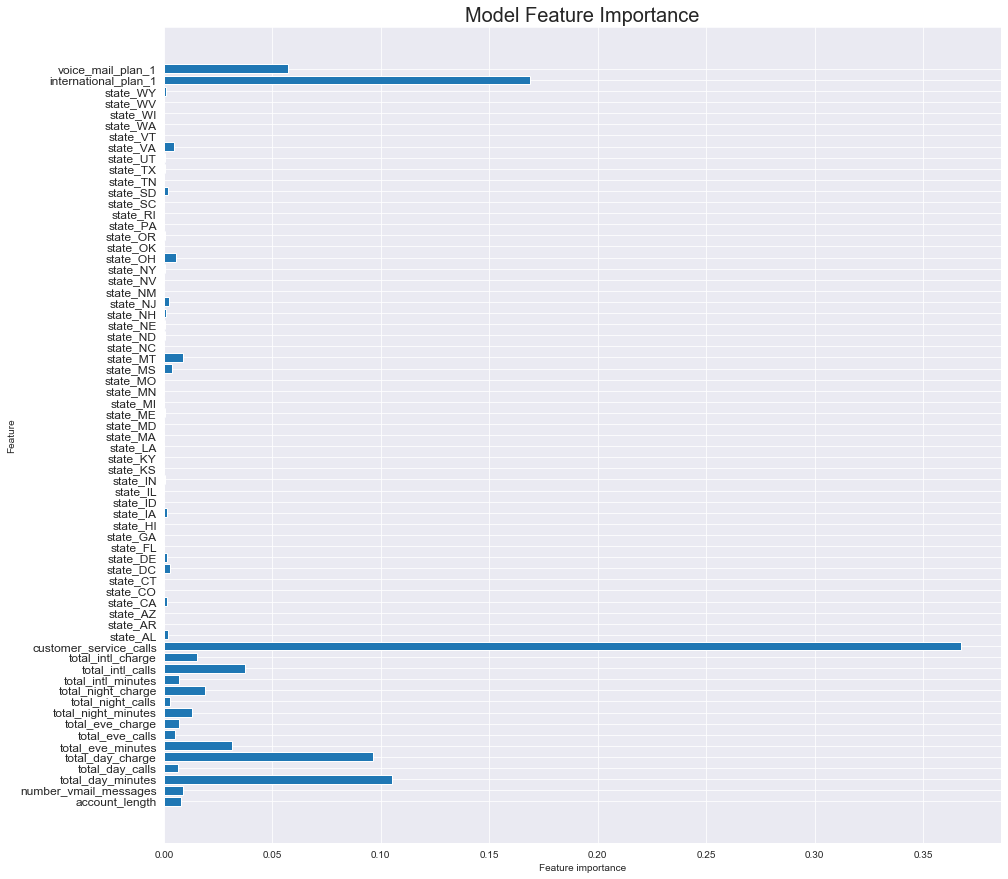

In [118]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', random_state = 15), MinMaxScaler())

**Score is better again - model 8 is the new best with score 0.788**, let's keep tuning.

## Model 9:  Gradient Boost - third tuning

Add more estimators

Validation recall scores: [0.7142857142857143, 0.7407407407407407, 0.7083333333333334, 0.7692307692307693, 0.6388888888888888]
Mean recall score:  0.7142958892958893
Confusion Matrix: 
 [[419   8]
 [ 26  46]]


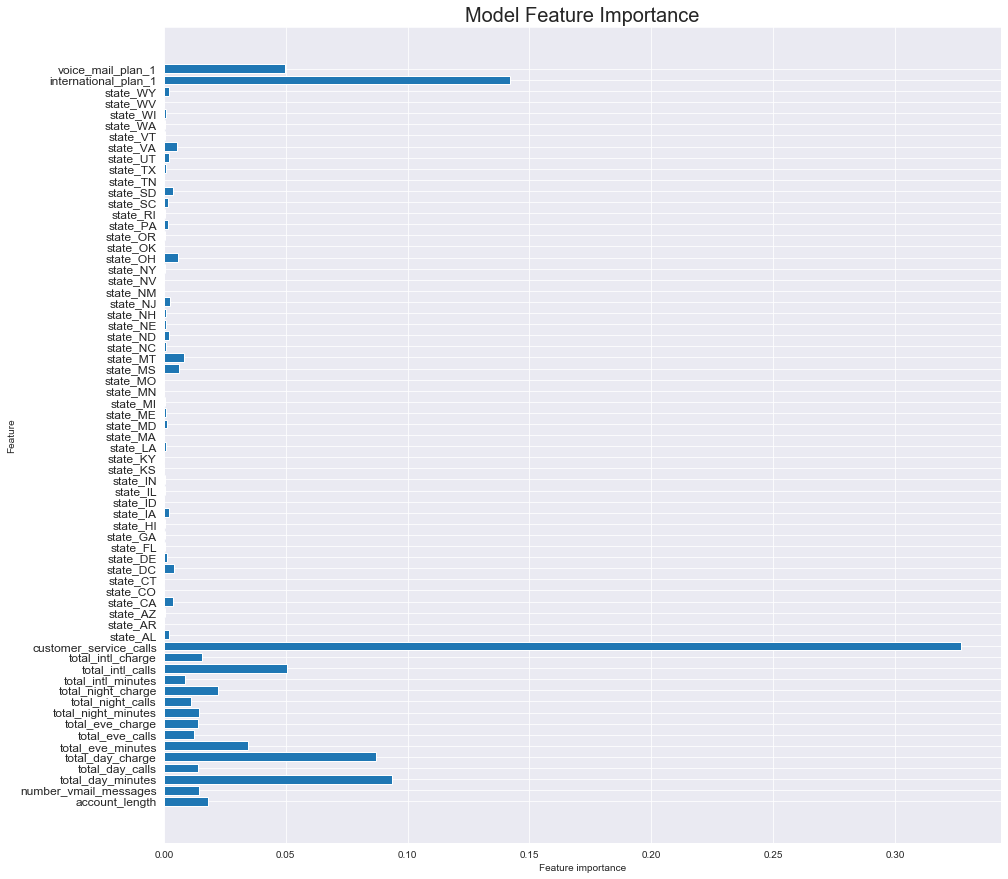

In [119]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', n_estimators = 1000, random_state = 15), MinMaxScaler())

Score got worse... so perhaps we keep n_estimators at 100...

## Model 10:  Gradient Boost - fourth tuning

Try `criterion = 'mse'`

Validation recall scores: [0.7571428571428571, 0.8148148148148148, 0.8055555555555556, 0.7692307692307693, 0.6944444444444444]
Mean recall score:  0.7682376882376882
Confusion Matrix: 
 [[409  18]
 [ 22  50]]


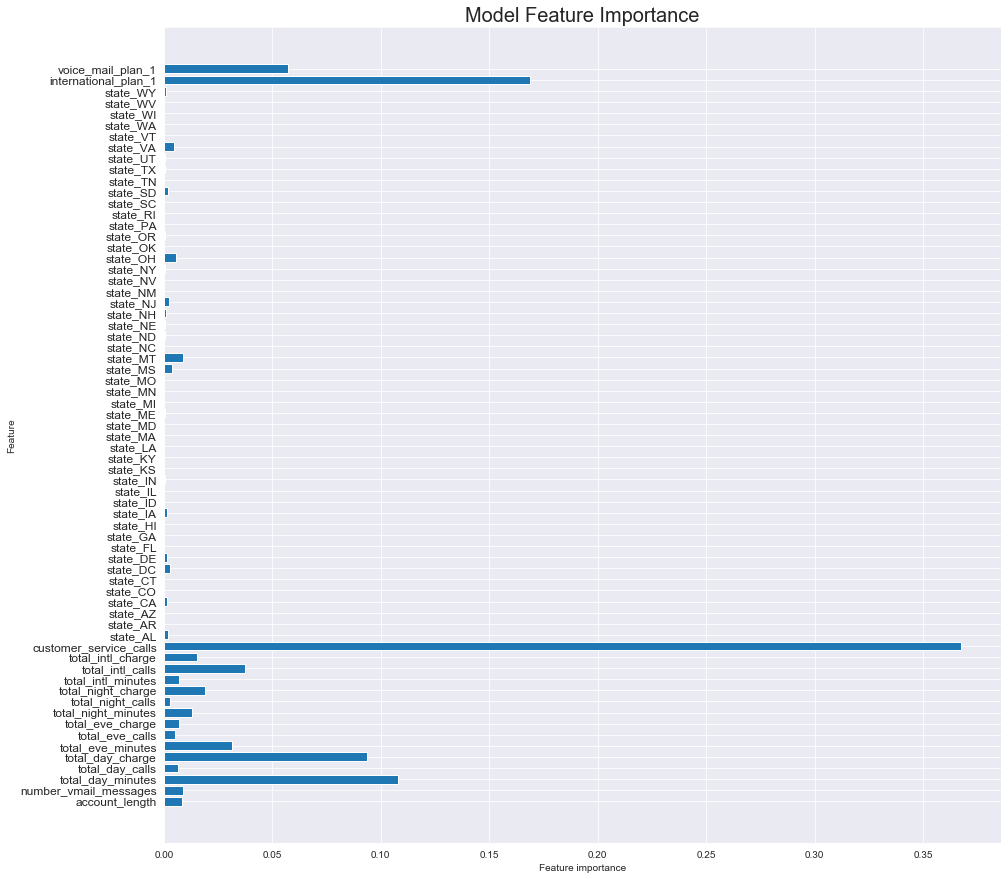

In [120]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', criterion = 'mse', random_state = 15), MinMaxScaler())

Not quiiite as good as model 8.

## Model 11: Gradient Boost - fifth tuning

Validation recall scores: [0.6714285714285714, 0.7407407407407407, 0.7361111111111112, 0.8, 0.6944444444444444]
Mean recall score:  0.7285449735449736
Confusion Matrix: 
 [[417  10]
 [ 22  50]]


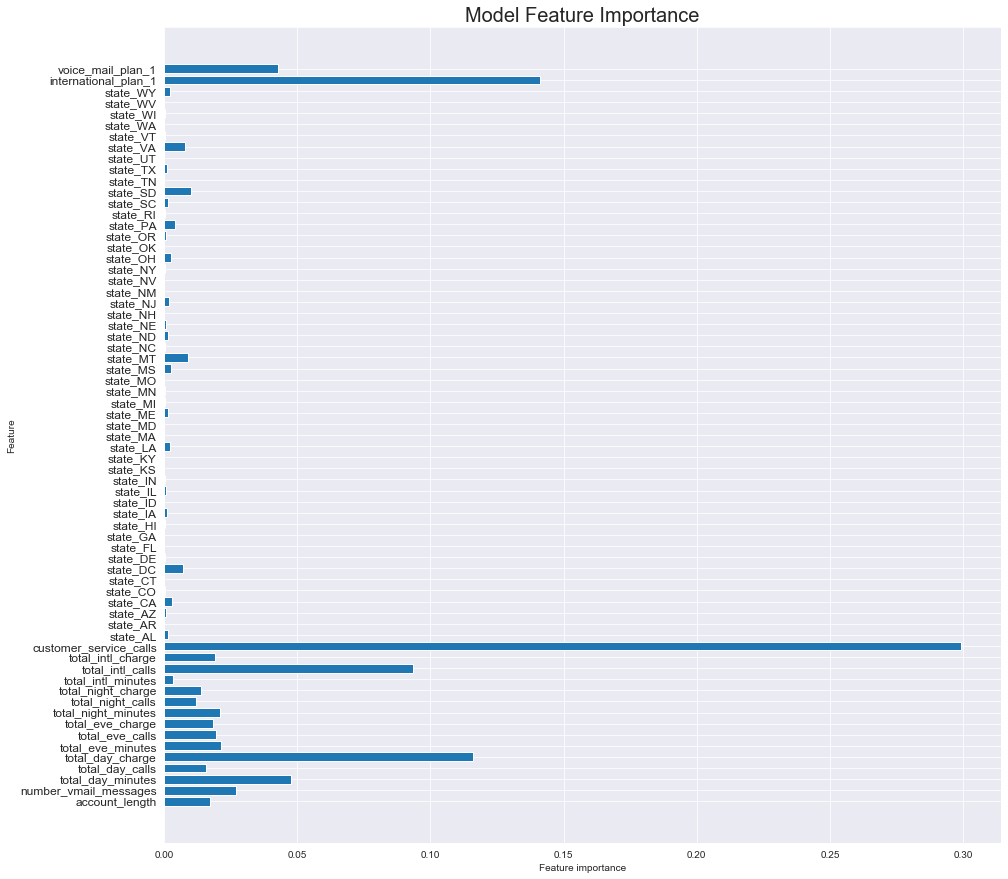

In [121]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.5, random_state = 15), MinMaxScaler())

Giving a higher learning rate made the score worse so let's decrease the learning rate.

## Model 12:  Gradient Boost - sixth tuning

Decrease the learning rate.

Validation recall scores: [0.8142857142857143, 0.8148148148148148, 0.8472222222222222, 0.9076923076923077, 0.7222222222222222]
Mean recall score:  0.8212474562474561
Confusion Matrix: 
 [[375  52]
 [ 20  52]]


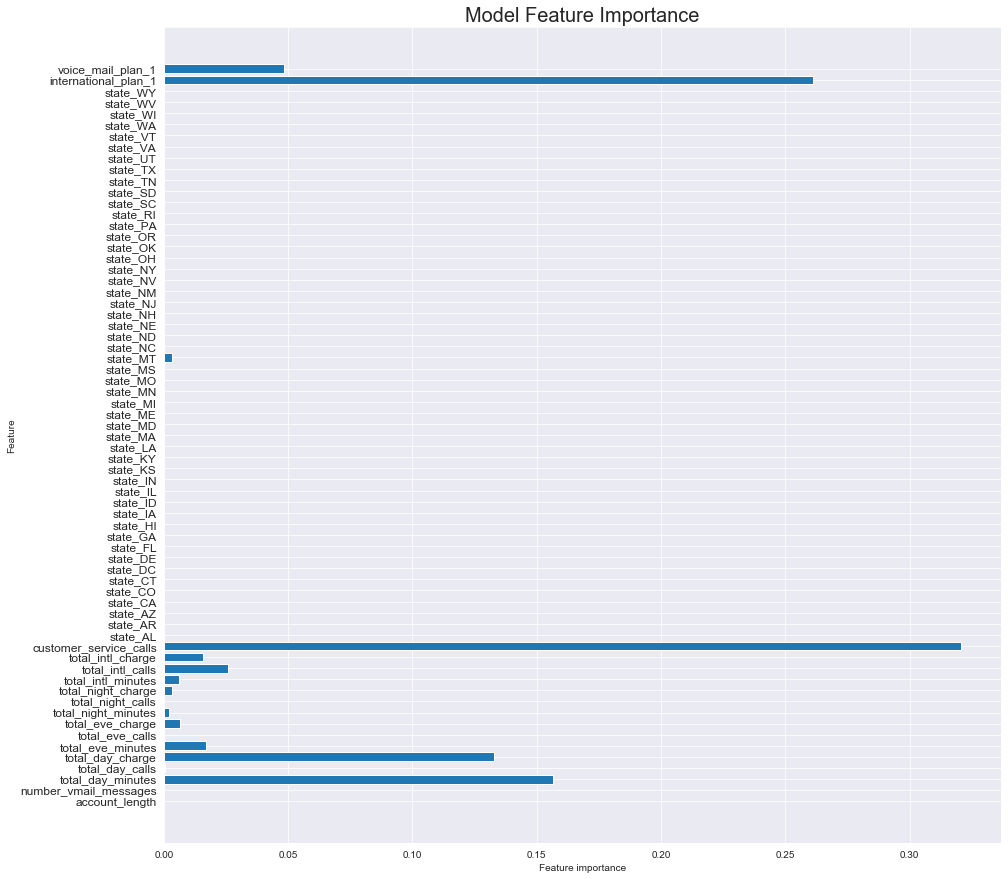

In [122]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, random_state = 15), MinMaxScaler())

**Best model so far: model 12 with validation recall score of 0.823.**

## Model 13:  Gradient Boost - seveth tuning

Add more depth - max_depth = 5

Validation recall scores: [0.8142857142857143, 0.7901234567901234, 0.8055555555555556, 0.8, 0.7638888888888888]
Mean recall score:  0.7947707231040565
Confusion Matrix: 
 [[401  26]
 [ 17  55]]


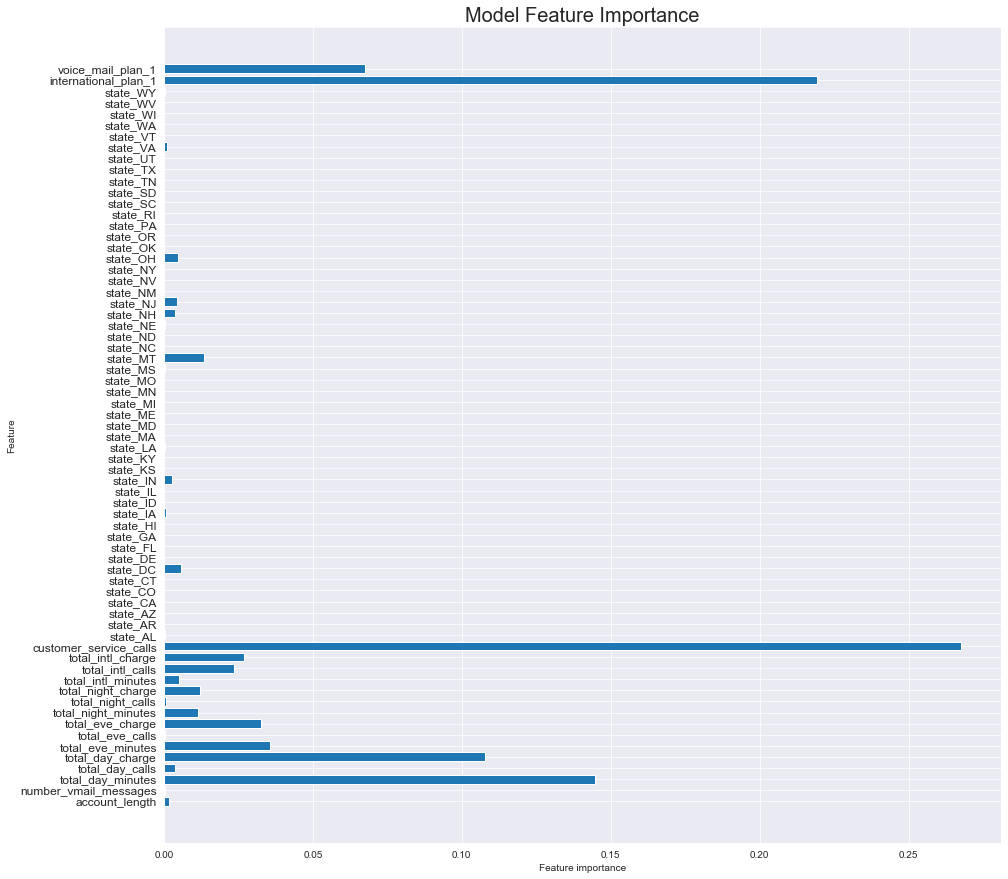

In [123]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, max_depth = 5,
                                                                 random_state = 15), MinMaxScaler())

Nope.

## Model 14:  Gradient Boost - eighth tuning

Max features is set to 10

Validation recall scores: [0.7857142857142857, 0.6666666666666666, 0.8055555555555556, 0.8615384615384616, 0.75]
Mean recall score:  0.7738949938949939
Confusion Matrix: 
 [[388  39]
 [ 18  54]]


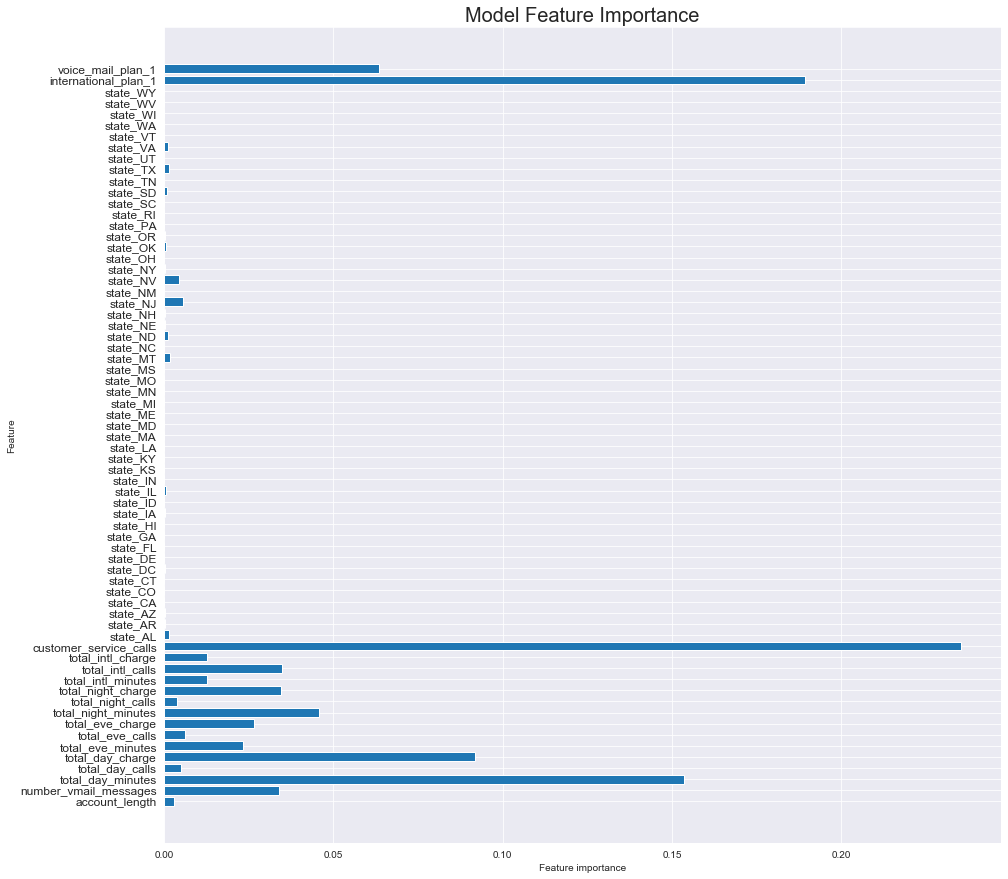

In [124]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, max_features = 10,
                                                                 random_state = 15), MinMaxScaler())

## Model 15:  Gradient Boost - ninth tuning

Increase max features:

Validation recall scores: [0.8285714285714286, 0.8271604938271605, 0.8472222222222222, 0.9076923076923077, 0.75]
Mean recall score:  0.8321292904626236
Confusion Matrix: 
 [[384  43]
 [ 18  54]]


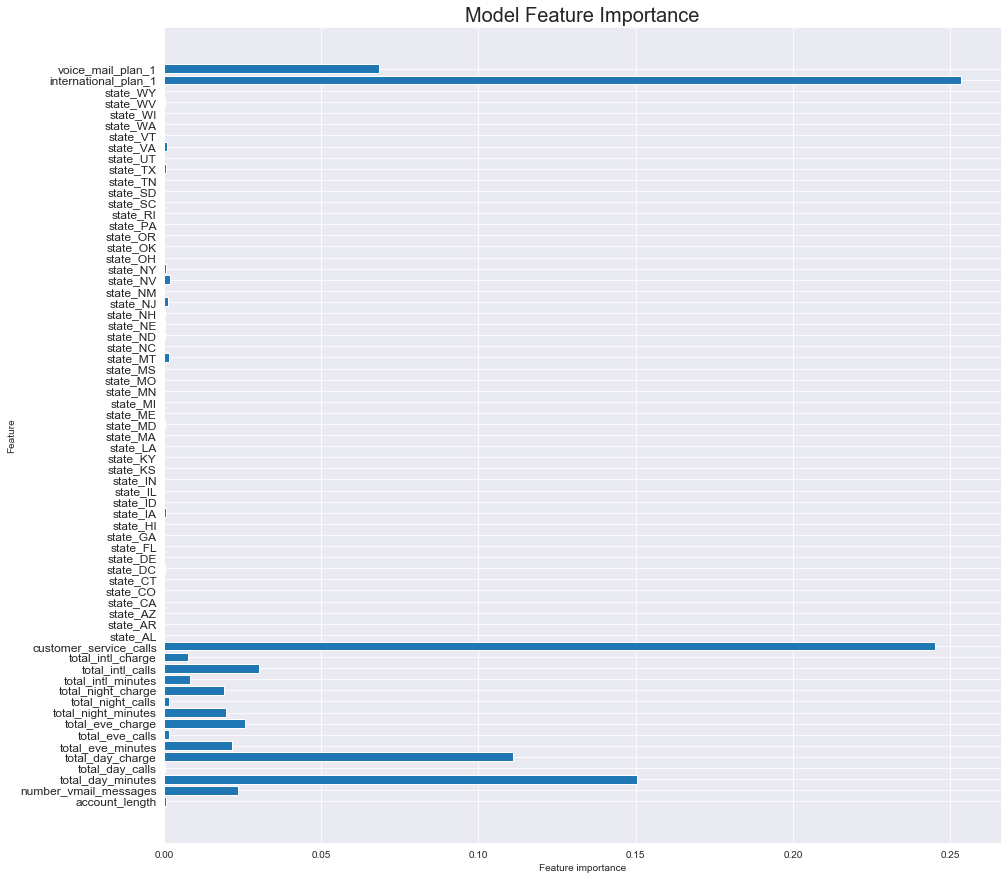

In [125]:
scale_balance_model(X_train, y_train, GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, max_features = 20,
                                                                 random_state = 15), MinMaxScaler())

**New Best Model:  model 15 with validation recall score of 0.846**.

### Best Model Parameters:

In [126]:
GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, max_features = 20, random_state = 15)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='exponential', max_depth=3,
                           max_features=20, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=15, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Using:
- SMOTE class balancing 
- MinMax Scaler
- Trained on X_t and validated on x_val/y_val

# Test on Best Model:

Let's try out our best model (model 15) on our test data...

In [127]:
ss = MinMaxScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)
    
smote = SMOTE(random_state = 15)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ss, y_train)
    
gb = GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.01, max_features = 20, random_state = 15)
gb.fit(X_train_resampled, y_train_resampled)

print(f'Train: {recall_score(y_train, gb.predict(X_train_ss))}')
print(f'Test:  {recall_score(y_test, gb.predict(X_test_ss))}')

Train: 0.8583333333333333
Test:  0.8455284552845529


# WHEN I DO `Y_SCORE` HERE, DO I USE X/Y-TRAIN-RESAMPLED OR JUST X/Y-TRAIN???

Better AUC score with the resampled data but not that much difference.

In [130]:
y_score = gb.fit(X_train_resampled, y_train_resampled).decision_function(X_test_ss)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print(f'AUC: {auc(fpr, tpr)}')

AUC: 0.9011125976238665


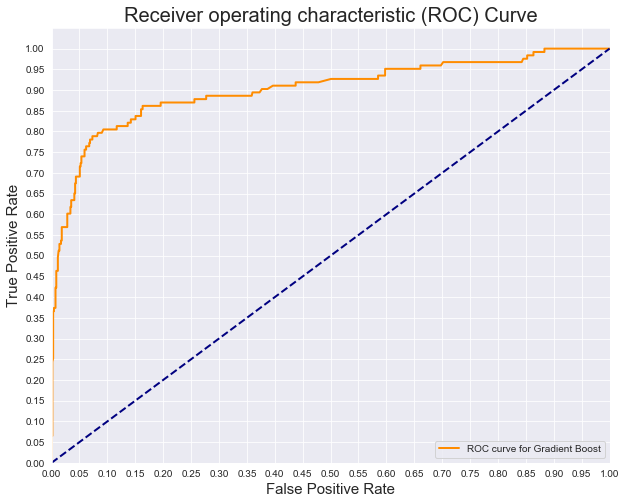

In [131]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve for Gradient Boost')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
plt.legend(loc='lower right')
plt.show()

NOTE:  The evaluation notes at the end of each model in this notebook might differ to what you see as the model results and that is because I hadn't set a random state for SMOTE in my modelling function.  Please ignore that I will adjust - model 15 was still the best performer.  